# XGBoost with Featexp Reduced Space

In this notebook we use the featexp package in order to identify and eliminate noisy features.
The steps below are shown in the featexp demo notebook found in the link at the bottom.


https://github.com/abhayspawar/featexp/blob/master/featexp_demo.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve
from joblib import dump, load

import xgboost as xgb

from featexp import univariate_plotter
from featexp import get_trend_stats
from featexp import get_univariate_plots

%matplotlib inline

In [2]:
#change read limit to -1 to load entire dataframe
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=100_000)

#drop columns
df_bus = df_bus.drop(columns=['latitude', 'longitude', 'postal_code'])

#make dataframe of numeric types
df_bus_numeric = df_bus.select_dtypes(include=[np.float64, np.int64]).copy()
print(df_bus_numeric.shape)


(100000, 102)


In [3]:
print(*df_bus_numeric.columns, sep=', ')

review_count, stars, road_type, GoodForKids, RestaurantsReservations, Caters, RestaurantsTableService, RestaurantsTakeOut, RestaurantsPriceRange2, OutdoorSeating, BikeParking, HasTV, RestaurantsGoodForGroups, RestaurantsDelivery, BusinessAcceptsCreditCards, BusinessAcceptsBitcoin, ByAppointmentOnly, AcceptsInsurance, GoodForDancing, CoatCheck, HappyHour, WheelchairAccessible, DogsAllowed, DriveThru, Corkage, BYOB, Open24Hours, RestaurantsCounterService, dessert, latenight, lunch, dinner, brunch, breakfast, garage, street, validated, lot, valet, romantic, intimate, classy, hipster, divey, touristy, trendy, upscale, casual, dj, background_music, no_music, jukebox, live, video, karaoke, monday, tuesday, friday, wednesday, thursday, sunday, saturday, straightperms, coloring, extensions, africanamerican, curly, kids, perms, asian, dairy_free, gluten_free, vegan, kosher, halal, soy_free, vegetarian, NoiseLevel, WiFi, Alcohol, RestaurantsAttire, BYOBCorkage, Smoking, AgesAllowed, Restaurants,

In [4]:
#features
X = df_bus_numeric.drop(['is_open'], axis=1)
#target
y = df_bus_numeric['is_open']

In [5]:
#get training data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

#further subdivision for validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42)

In [6]:
#helper function

def get_imp_df(xgb_model):
    imp = pd.DataFrame(np.asarray(list(xgb_model.get_fscore().keys())))
    imp.columns = ['Feature']
    imp['importance'] = np.asarray(list(xgb_model.get_fscore().values()))
    imp = imp.sort_values(by=['importance'], ascending=False)
    imp = imp.reset_index(drop=True)
    return (imp)

In [7]:
data_train = X_train.reset_index(drop=True)
data_train['is_open'] = y_train.reset_index(drop=True)
data_test = X_val.reset_index(drop=True)
data_test['is_open'] = y_val.reset_index(drop=True)

                                        Plots for review_count                                        
                                           Train data plots                                           


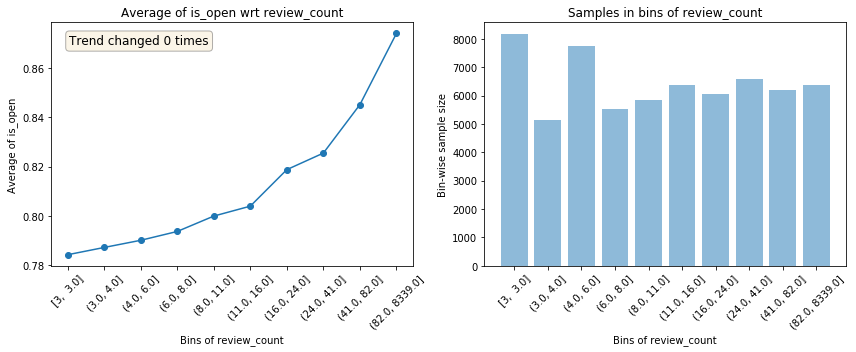

                                           Test data plots                                            


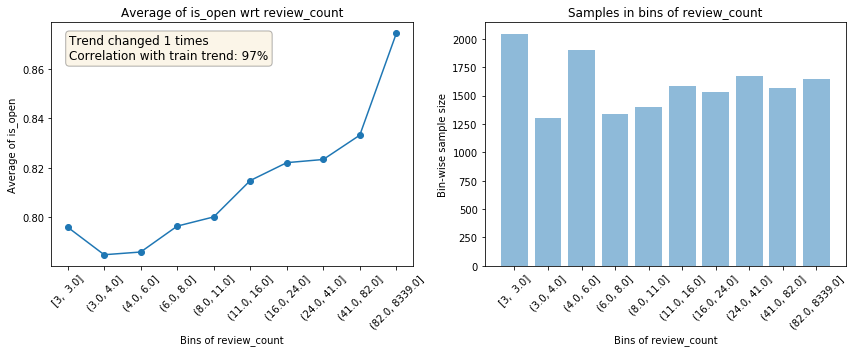

--------------------------------------------------------------------------------------------------------------


                                           Plots for stars                                            
                                           Train data plots                                           


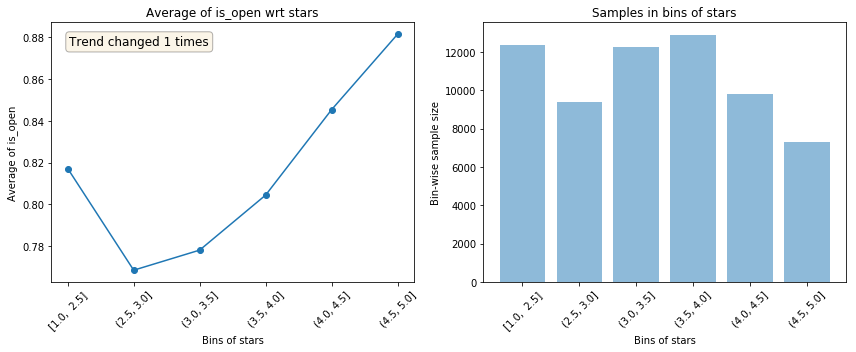

                                           Test data plots                                            


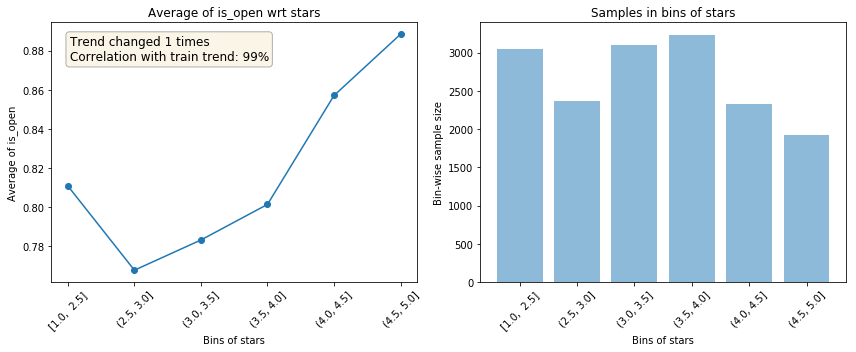

--------------------------------------------------------------------------------------------------------------


                                         Plots for road_type                                          
                                           Train data plots                                           


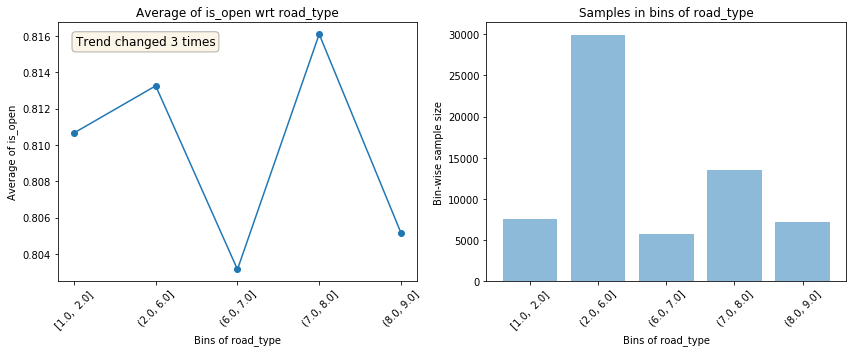

                                           Test data plots                                            


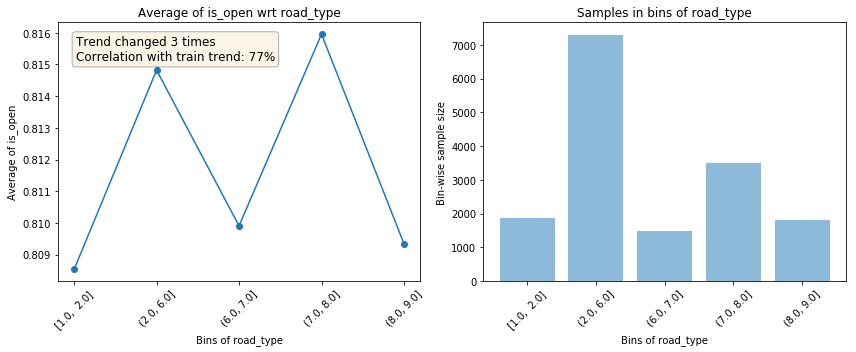

--------------------------------------------------------------------------------------------------------------


                                        Plots for GoodForKids                                         
                                           Train data plots                                           


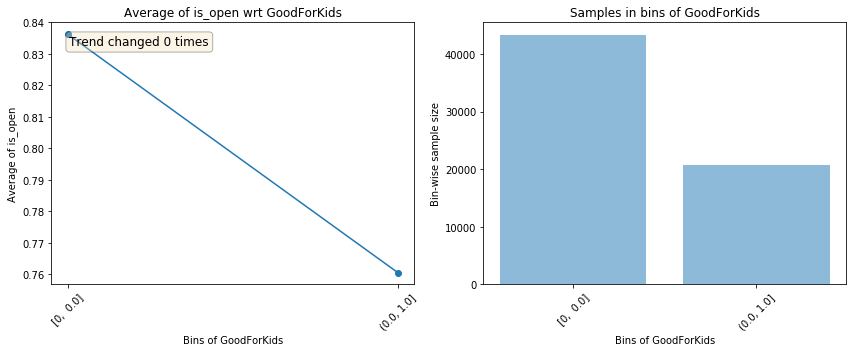

                                           Test data plots                                            


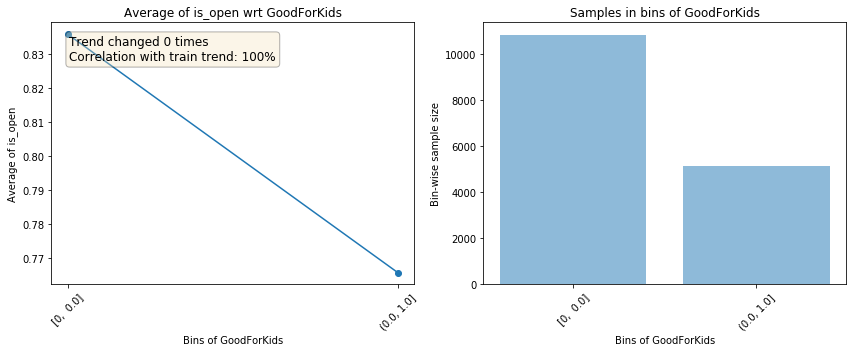

--------------------------------------------------------------------------------------------------------------


                                  Plots for RestaurantsReservations                                   
                                           Train data plots                                           


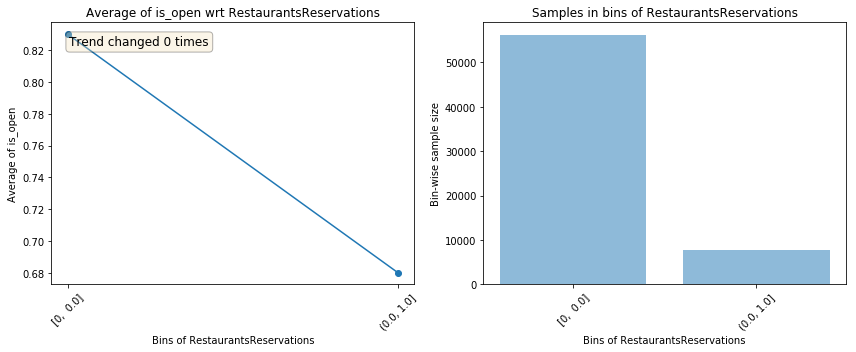

                                           Test data plots                                            


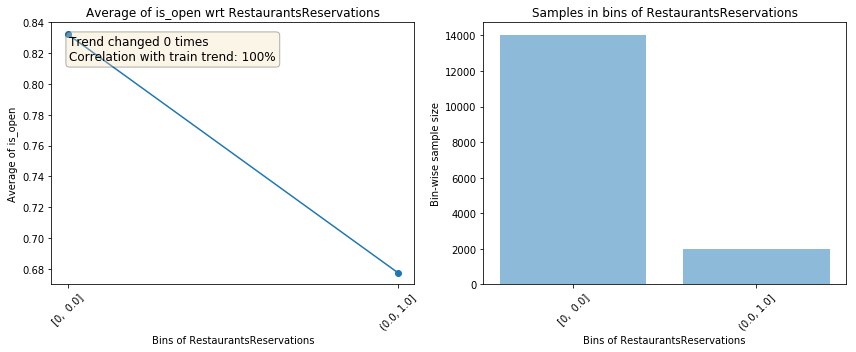

--------------------------------------------------------------------------------------------------------------


                                           Plots for Caters                                           
                                           Train data plots                                           


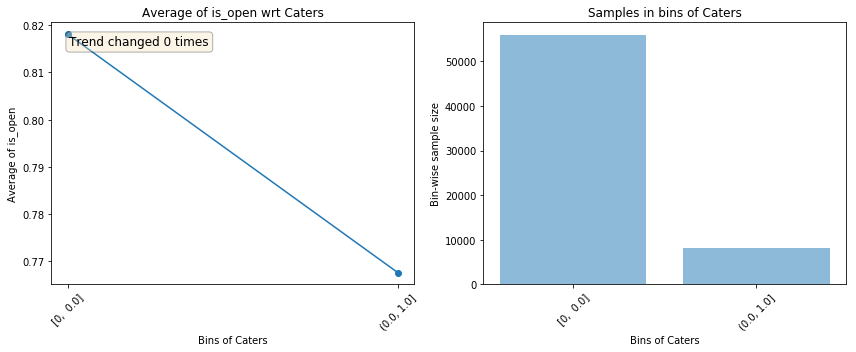

                                           Test data plots                                            


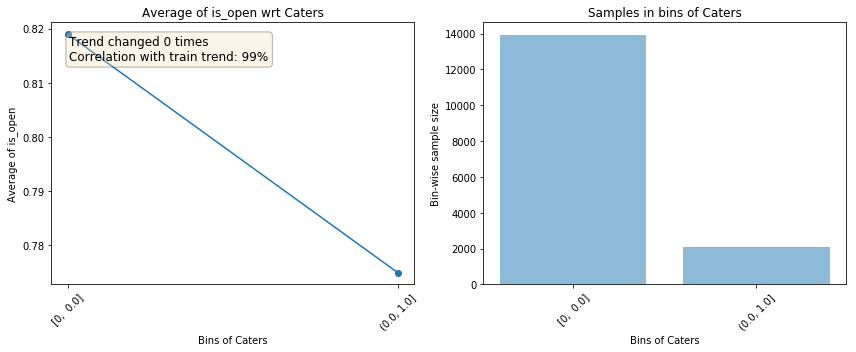

--------------------------------------------------------------------------------------------------------------


                                  Plots for RestaurantsTableService                                   
                                           Train data plots                                           


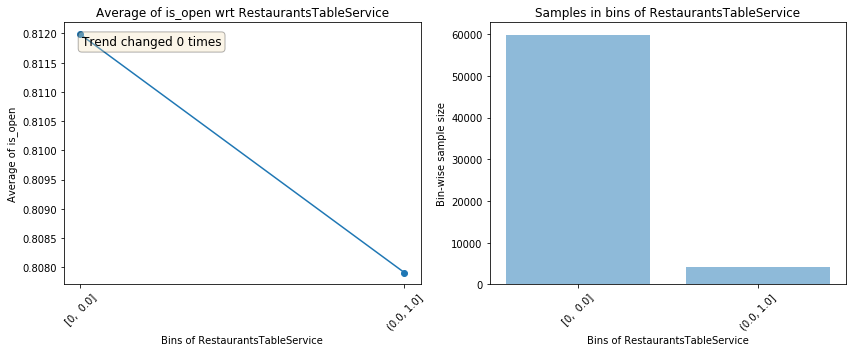

                                           Test data plots                                            


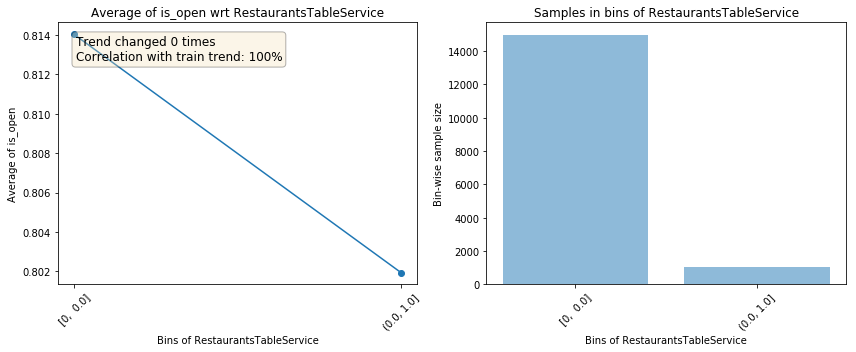

--------------------------------------------------------------------------------------------------------------


                                     Plots for RestaurantsTakeOut                                     
                                           Train data plots                                           


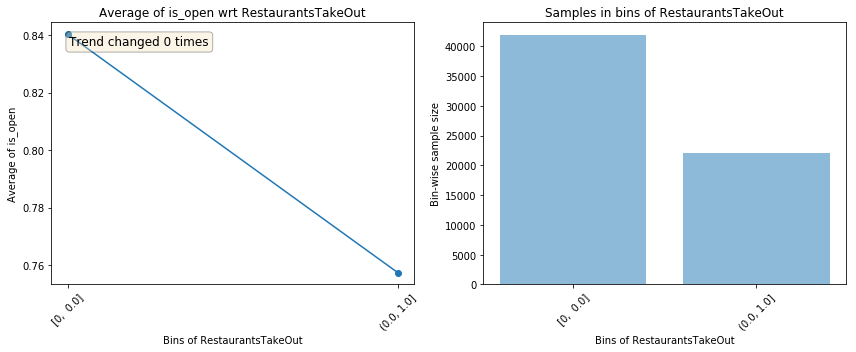

                                           Test data plots                                            


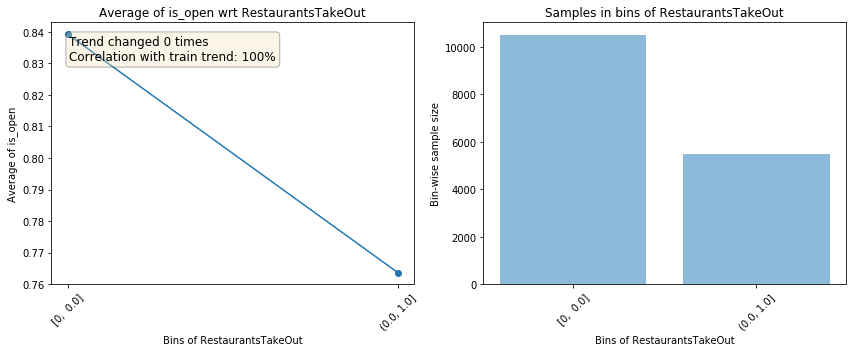

--------------------------------------------------------------------------------------------------------------


                                   Plots for RestaurantsPriceRange2                                   
                                           Train data plots                                           


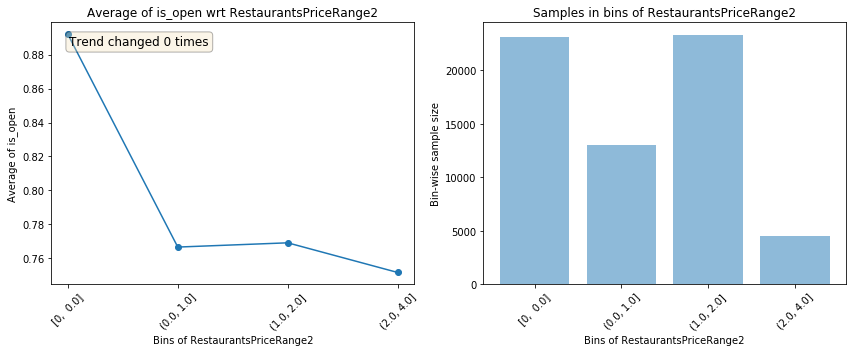

                                           Test data plots                                            


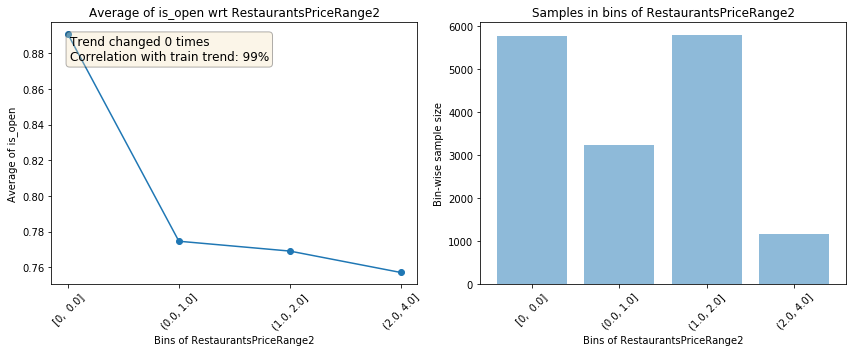

--------------------------------------------------------------------------------------------------------------


                                       Plots for OutdoorSeating                                       
                                           Train data plots                                           


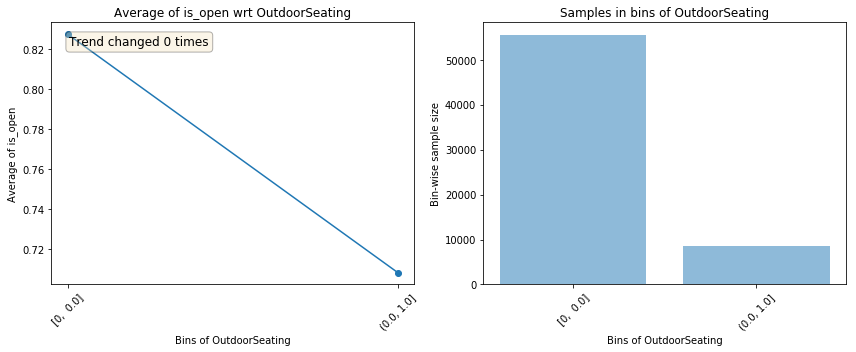

                                           Test data plots                                            


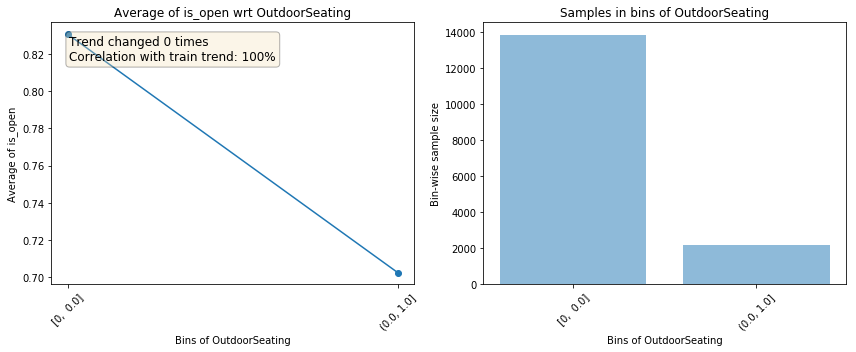

--------------------------------------------------------------------------------------------------------------




In [8]:
# plots univariate plots of first 10 columns in data_train
get_univariate_plots(data=data_train, target_col='is_open', 
                     features_list=data_train.columns[0:10], 
                     data_test=data_test)

                                   Plots for RestaurantsPriceRange2                                   
                                           Train data plots                                           


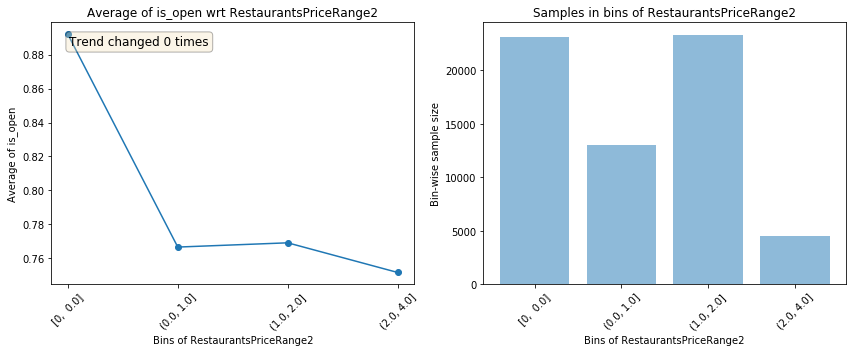

                                           Test data plots                                            


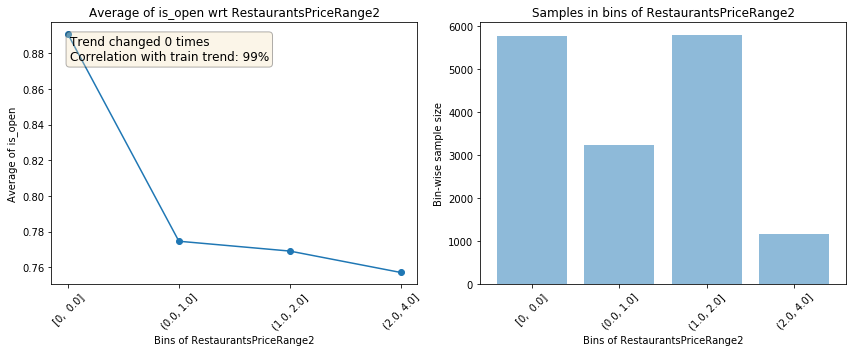

--------------------------------------------------------------------------------------------------------------




In [9]:
# Get grouped data, mean target and sample size of each group using univariate_plotter()
# With train and test data:
grouped_train, grouped_test = univariate_plotter(data=data_train, target_col='is_open', 
                                                 feature='RestaurantsPriceRange2',
                                                 data_test=data_test)

In [10]:
#Grouped data showing bin level stats
grouped_train 

,RestaurantsPriceRange2,Samples_in_bin,is_open_mean,RestaurantsPriceRange2_mean
0,"[0, 0.0]",23111,0.891999,0.000000
1,"(0.0, 1.0]",13032,0.766575,1.000000
2,"(1.0, 2.0]",23324,0.769079,2.000000
3,"(2.0, 4.0]",4533,0.751599,3.170527


# Training Model With All Features

In [11]:
#load into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, missing=np.nan)

params = {'max_depth':8, 
          'learning_rate':0.1, 
          'silent':0, 
          'objective':'binary:logistic', 
          'min_child_weight':500,
          'eval_metric' : 'auc', 
          'nthread':8 }

xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain, 'train'),
                                                  (dval, 'val')], 
                      early_stopping_rounds=25) #, (dtest, 'test')

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.727665	val-auc:0.725794
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 25 rounds.
[1]	train-auc:0.73376	val-auc:0.730296
[2]	train-auc:0.735836	val-auc:0.733226
[3]	train-auc:0.740097	val-auc:0.737611
[4]	train-auc:0.740543	val-auc:0.737703
[5]	train-auc:0.7407	val-auc:0.737917
[6]	train-auc:0.741295	val-auc:0.738472
[7]	train-auc:0.741476	val-auc:0.738876
[8]	train-auc:0.741522	val-auc:0.738982
[9]	train-auc:0.743314	val-auc:0.740003
[10]	train-auc:0.744489	val-auc:0.741282
[11]	train-auc:0.745333	val-auc:0.741571
[12]	train-auc:0.746421	val-auc:0.7427
[13]	train-auc:0.747207	val-auc:0.743653
[14]	train-auc:0.749132	val-auc:0.745341
[15]	train-auc:0.749935	val-auc:0.746311
[16]	train-auc:0.74989	val-auc:0.746446
[17]	train-auc:0.75157	val-auc:0.748078
[18]	train-auc:0.75381	val-auc:0.749972
[19]	train-auc:0.75594	val-auc:0.75154
[20]	train-auc:0.757034	val-auc:0.752667
[21]	train-auc:0.758

[196]	train-auc:0.802207	val-auc:0.788778
[197]	train-auc:0.802266	val-auc:0.788767
[198]	train-auc:0.802331	val-auc:0.788806
[199]	train-auc:0.802467	val-auc:0.789023
[200]	train-auc:0.802622	val-auc:0.789207
[201]	train-auc:0.802685	val-auc:0.789338
[202]	train-auc:0.802758	val-auc:0.789324
[203]	train-auc:0.802887	val-auc:0.789433
[204]	train-auc:0.802962	val-auc:0.789428
[205]	train-auc:0.803027	val-auc:0.789438
[206]	train-auc:0.803124	val-auc:0.789531
[207]	train-auc:0.803228	val-auc:0.789559
[208]	train-auc:0.803274	val-auc:0.78959
[209]	train-auc:0.803394	val-auc:0.789644
[210]	train-auc:0.803473	val-auc:0.789658
[211]	train-auc:0.803525	val-auc:0.789679
[212]	train-auc:0.803597	val-auc:0.789659
[213]	train-auc:0.803704	val-auc:0.789737
[214]	train-auc:0.803752	val-auc:0.78976
[215]	train-auc:0.803869	val-auc:0.789816
[216]	train-auc:0.803931	val-auc:0.789828
[217]	train-auc:0.803987	val-auc:0.789862
[218]	train-auc:0.80406	val-auc:0.78992
[219]	train-auc:0.80414	val-auc:0.7899

[392]	train-auc:0.813423	val-auc:0.793377
[393]	train-auc:0.813492	val-auc:0.793404
[394]	train-auc:0.813529	val-auc:0.793412
[395]	train-auc:0.81359	val-auc:0.793428
[396]	train-auc:0.813628	val-auc:0.793387
[397]	train-auc:0.813637	val-auc:0.793401
[398]	train-auc:0.813713	val-auc:0.793447
[399]	train-auc:0.813757	val-auc:0.793434


In [12]:
dtest = xgb.DMatrix(X_test)

y_test_pred = [round(x) for x in xgb_model.predict(dtest)]

              precision    recall  f1-score   support

           0       0.71      0.30      0.42      3796
           1       0.86      0.97      0.91     16204

   micro avg       0.84      0.84      0.84     20000
   macro avg       0.79      0.64      0.67     20000
weighted avg       0.83      0.84      0.82     20000

--------------------------------------------------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


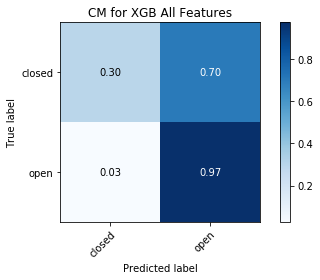

--------------------------------------------------


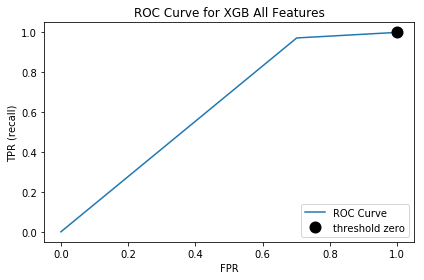

Area Under Curve = 0.6355
--------------------------------------------------


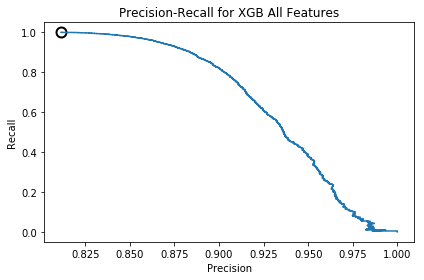

In [13]:

print(classification_report(y_test, y_test_pred))
print(50*'-')
plot_help.plot_confusion_matrix(y_test, y_test_pred, ['closed', 'open'], normalize=True,
                                title='XGB All Features')
print(50*'-')
plot_help.plot_roc_curve(y_test, y_test_pred, 'XGB All Features')
print(50*'-')
plot_help.plot_prc_curve(y_test, xgb_model.predict(dtest), 'XGB All Features')

# Extract Feature Importance

In [14]:
xgb_stats = get_trend_stats(data=data_train, 
                            target_col='is_open', 
                            data_test=data_test)

Only one bin created for BYOB. Correlation can't be calculated
Only one bin created for Open24Hours. Correlation can't be calculated
Only one bin created for RestaurantsCounterService. Correlation can't be calculated
Only one bin created for no_music. Correlation can't be calculated
Only one bin created for video. Correlation can't be calculated
Only one bin created for dairy_free. Correlation can't be calculated
Only one bin created for kosher. Correlation can't be calculated
Only one bin created for halal. Correlation can't be calculated
Only one bin created for soy_free. Correlation can't be calculated
Returning stats for all numeric features


In [15]:
# get xgboost importances in dataframe
importance_df = get_imp_df(xgb_model) 
xgb_stats = pd.merge(xgb_stats, importance_df, how='left', on='Feature')
xgb_stats['importance'] = xgb_stats['importance'].fillna(0)

xgb_stats.head()

,Feature,Trend_changes,Trend_changes_test,Trend_correlation,importance
0,review_count,0,1,0.971447,492.0
1,stars,1,1,0.991402,266.0
2,road_type,3,3,0.778209,65.0
3,GoodForKids,0,0,1.000000,42.0
4,RestaurantsReservations,0,0,1.000000,23.0


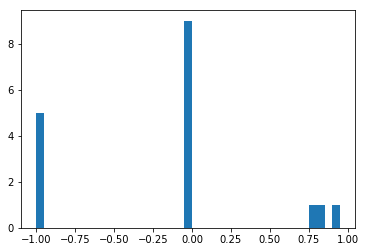

In [16]:
plt.hist(xgb_stats.Trend_correlation, bins=np.arange(-1,1,0.05))
plt.show()

# Drop features with less than 0.95 Correlation

In [17]:
#keep only strong correlations
xgb_95 = xgb_stats[(xgb_stats['Trend_correlation']<=0.95) & (xgb_stats['Trend_correlation']>= -0.95)].copy()

noisy = list(xgb_95['Feature'])

print(noisy)

['road_type', 'BYOB', 'Open24Hours', 'RestaurantsCounterService', 'no_music', 'video', 'dairy_free', 'kosher', 'halal', 'soy_free', 'useful', 'span_checkin']


In [18]:
#DMatrix 
dtrain_95 = xgb.DMatrix(X_train.drop(noisy, axis=1), label=y_train, missing=np.nan)
dval_95 = xgb.DMatrix(X_val.drop(noisy, axis=1), label=y_val, missing=np.nan)

xgb_model = xgb.train(params, dtrain_95, 400, evals=[(dtrain_95, 'train'),
                                                  (dval_95, 'val')], 
                      early_stopping_rounds=25) #, (dtest, 'test')

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.727944	val-auc:0.725155
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 25 rounds.
[1]	train-auc:0.733448	val-auc:0.72941
[2]	train-auc:0.735478	val-auc:0.731985
[3]	train-auc:0.738995	val-auc:0.735543
[4]	train-auc:0.73867	val-auc:0.73563
[5]	train-auc:0.739616	val-auc:0.73641
[6]	train-auc:0.740222	val-auc:0.737488
[7]	train-auc:0.741911	val-auc:0.738727
[8]	train-auc:0.741661	val-auc:0.738909
[9]	train-auc:0.742679	val-auc:0.73952
[10]	train-auc:0.743714	val-auc:0.740593
[11]	train-auc:0.743767	val-auc:0.740757
[12]	train-auc:0.746829	val-auc:0.743104
[13]	train-auc:0.747461	val-auc:0.743911
[14]	train-auc:0.747961	val-auc:0.74446
[15]	train-auc:0.748431	val-auc:0.744951
[16]	train-auc:0.74931	val-auc:0.745611
[17]	train-auc:0.751028	val-auc:0.747053
[18]	train-auc:0.752557	val-auc:0.748249
[19]	train-auc:0.753812	val-auc:0.749683
[20]	train-auc:0.754296	val-auc:0.750242
[21]	train-auc:0.

[196]	train-auc:0.798778	val-auc:0.787319
[197]	train-auc:0.798831	val-auc:0.787359
[198]	train-auc:0.798871	val-auc:0.787376
[199]	train-auc:0.798917	val-auc:0.787376
[200]	train-auc:0.798996	val-auc:0.787421
[201]	train-auc:0.799075	val-auc:0.787453
[202]	train-auc:0.799144	val-auc:0.787431
[203]	train-auc:0.799196	val-auc:0.78751
[204]	train-auc:0.799273	val-auc:0.787556
[205]	train-auc:0.79933	val-auc:0.787566
[206]	train-auc:0.799435	val-auc:0.787654
[207]	train-auc:0.79951	val-auc:0.787708
[208]	train-auc:0.799575	val-auc:0.787766
[209]	train-auc:0.799616	val-auc:0.787777
[210]	train-auc:0.799691	val-auc:0.787817
[211]	train-auc:0.799719	val-auc:0.78777
[212]	train-auc:0.799786	val-auc:0.787807
[213]	train-auc:0.799851	val-auc:0.787847
[214]	train-auc:0.799879	val-auc:0.787869
[215]	train-auc:0.799916	val-auc:0.787876
[216]	train-auc:0.799998	val-auc:0.787916
[217]	train-auc:0.800107	val-auc:0.788003
[218]	train-auc:0.80018	val-auc:0.788052
[219]	train-auc:0.800242	val-auc:0.7881

[393]	train-auc:0.80818	val-auc:0.792715
[394]	train-auc:0.808242	val-auc:0.792812
[395]	train-auc:0.808301	val-auc:0.792871
[396]	train-auc:0.808366	val-auc:0.792899
[397]	train-auc:0.808393	val-auc:0.792925
[398]	train-auc:0.808437	val-auc:0.792959
[399]	train-auc:0.808485	val-auc:0.792965


              precision    recall  f1-score   support

           0       0.71      0.29      0.41      3796
           1       0.85      0.97      0.91     16204

   micro avg       0.84      0.84      0.84     20000
   macro avg       0.78      0.63      0.66     20000
weighted avg       0.83      0.84      0.82     20000

--------------------------------------------------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


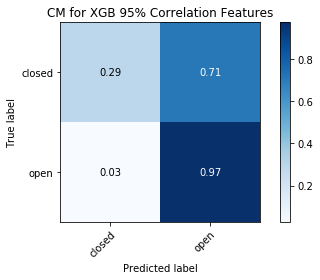

--------------------------------------------------


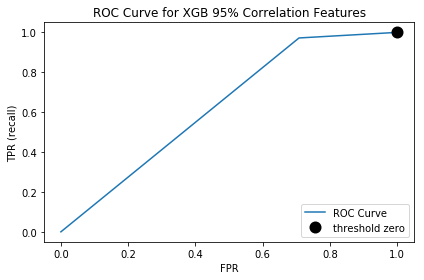

Area Under Curve = 0.6321
--------------------------------------------------


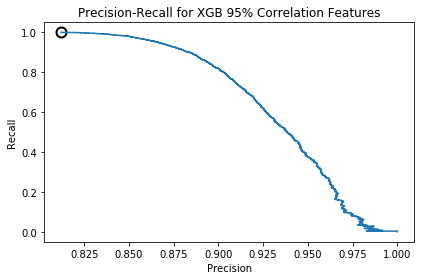

In [19]:
dtest_95 = xgb.DMatrix(X_test.drop(noisy, axis=1))

y_pred_95 = [round(x) for x in xgb_model.predict(dtest_95)]


print(classification_report(y_test, y_pred_95))
print(50*'-')
plot_help.plot_confusion_matrix(y_test, y_pred_95, ['closed', 'open'], normalize=True,
                                title='XGB 95% Correlation Features')
print(50*'-')
plot_help.plot_roc_curve(y_test, y_pred_95, 'XGB 95% Correlation Features')
print(50*'-')
plot_help.plot_prc_curve(y_test, xgb_model.predict(dtest_95), 'XGB 95% Correlation Features')

# Drop features with less than 0.95 corr and 40 feature importance

In [20]:
#keep only strong correlations
xgb_40 = xgb_95[(xgb_95['importance']<40)].copy()

#add from previous
noisy_40 = list(xgb_40['Feature']) + noisy

print(noisy_40)

['BYOB', 'Open24Hours', 'RestaurantsCounterService', 'no_music', 'video', 'dairy_free', 'kosher', 'halal', 'soy_free', 'road_type', 'BYOB', 'Open24Hours', 'RestaurantsCounterService', 'no_music', 'video', 'dairy_free', 'kosher', 'halal', 'soy_free', 'useful', 'span_checkin']


In [21]:
#DMatrix 
dtrain_40 = xgb.DMatrix(X_train.drop(noisy_40, axis=1), label=y_train, missing=np.nan)
dval_40 = xgb.DMatrix(X_val.drop(noisy_40, axis=1), label=y_val, missing=np.nan)

xgb_model = xgb.train(params, dtrain_40, 400, evals=[(dtrain_40, 'train'),
                                                  (dval_40, 'val')], 
                      early_stopping_rounds=25) #, (dtest, 'test')

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.727944	val-auc:0.725155
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 25 rounds.
[1]	train-auc:0.733448	val-auc:0.72941
[2]	train-auc:0.735478	val-auc:0.731985
[3]	train-auc:0.738995	val-auc:0.735543
[4]	train-auc:0.73867	val-auc:0.73563
[5]	train-auc:0.739616	val-auc:0.73641
[6]	train-auc:0.740222	val-auc:0.737488
[7]	train-auc:0.741911	val-auc:0.738727
[8]	train-auc:0.741661	val-auc:0.738909
[9]	train-auc:0.742679	val-auc:0.73952
[10]	train-auc:0.743714	val-auc:0.740593
[11]	train-auc:0.743767	val-auc:0.740757
[12]	train-auc:0.746829	val-auc:0.743104
[13]	train-auc:0.747461	val-auc:0.743911
[14]	train-auc:0.747961	val-auc:0.74446
[15]	train-auc:0.748431	val-auc:0.744951
[16]	train-auc:0.74931	val-auc:0.745611
[17]	train-auc:0.751028	val-auc:0.747053
[18]	train-auc:0.752557	val-auc:0.748249
[19]	train-auc:0.753812	val-auc:0.749683
[20]	train-auc:0.754296	val-auc:0.750242
[21]	train-auc:0.

[196]	train-auc:0.798778	val-auc:0.787319
[197]	train-auc:0.798831	val-auc:0.787359
[198]	train-auc:0.798871	val-auc:0.787376
[199]	train-auc:0.798917	val-auc:0.787376
[200]	train-auc:0.798996	val-auc:0.787421
[201]	train-auc:0.799075	val-auc:0.787453
[202]	train-auc:0.799144	val-auc:0.787431
[203]	train-auc:0.799196	val-auc:0.78751
[204]	train-auc:0.799273	val-auc:0.787556
[205]	train-auc:0.79933	val-auc:0.787566
[206]	train-auc:0.799435	val-auc:0.787654
[207]	train-auc:0.79951	val-auc:0.787708
[208]	train-auc:0.799575	val-auc:0.787766
[209]	train-auc:0.799616	val-auc:0.787777
[210]	train-auc:0.799691	val-auc:0.787817
[211]	train-auc:0.799719	val-auc:0.78777
[212]	train-auc:0.799786	val-auc:0.787807
[213]	train-auc:0.799851	val-auc:0.787847
[214]	train-auc:0.799879	val-auc:0.787869
[215]	train-auc:0.799916	val-auc:0.787876
[216]	train-auc:0.799998	val-auc:0.787916
[217]	train-auc:0.800107	val-auc:0.788003
[218]	train-auc:0.80018	val-auc:0.788052
[219]	train-auc:0.800242	val-auc:0.7881

[393]	train-auc:0.80818	val-auc:0.792715
[394]	train-auc:0.808242	val-auc:0.792812
[395]	train-auc:0.808301	val-auc:0.792871
[396]	train-auc:0.808366	val-auc:0.792899
[397]	train-auc:0.808393	val-auc:0.792925
[398]	train-auc:0.808437	val-auc:0.792959
[399]	train-auc:0.808485	val-auc:0.792965


              precision    recall  f1-score   support

           0       0.71      0.29      0.41      3796
           1       0.85      0.97      0.91     16204

   micro avg       0.84      0.84      0.84     20000
   macro avg       0.78      0.63      0.66     20000
weighted avg       0.83      0.84      0.82     20000

--------------------------------------------------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


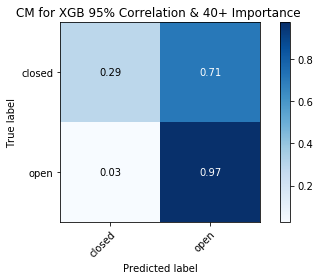

--------------------------------------------------


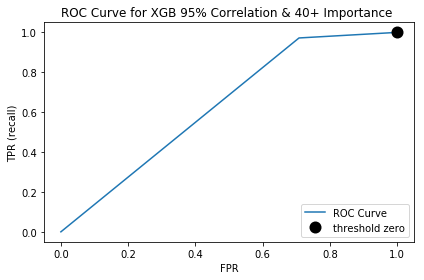

Area Under Curve = 0.6321
--------------------------------------------------


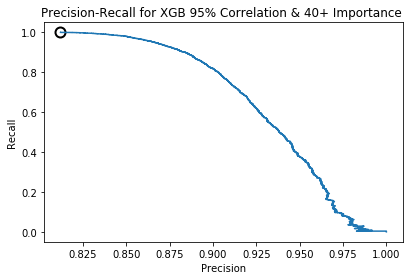

In [22]:
dtest_40 = xgb.DMatrix(X_test.drop(noisy_40, axis=1))

y_pred_40 = [round(x) for x in xgb_model.predict(dtest_40)]


print(classification_report(y_test, y_pred_40))
print(50*'-')
plot_help.plot_confusion_matrix(y_test, y_pred_40, ['closed', 'open'], normalize=True,
                                title='XGB 95% Correlation & 40+ Importance ')
print(50*'-')
plot_help.plot_roc_curve(y_test, y_pred_40, 'XGB 95% Correlation & 40+ Importance ')
print(50*'-')
plot_help.plot_prc_curve(y_test, xgb_model.predict(dtest_40), 'XGB 95% Correlation & 40+ Importance ')